In [1]:
import numpy as np
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import QTable
import numpy as np
from reproject import reproject_interp
import os 
from tqdm import tqdm 

plt.style.use('paper.mplstyle')

In [2]:
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue.fits' %root_dir)
table_muse = QTable.read('%s/data_misc/Nebulae_catalogue_v3/Nebulae_catalogue_v3.fits' %root_dir)

table = table[table['flag_star_MUSE']!=1]
table_muse = table_muse[table_muse['flag_star']!=1]

In [ ]:
def get_files(endswith, root_dir): 

    file_list = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(endswith):
                if '628e' in file: 
                    continue
                else: 
                    print(os.path.join(root, file))
                    file_list += [os.path.join(root, file)]

    print('TOTAL NUMBER OF FILES:', len(file_list))

    return file_list

files_maps = get_files('_hst_ha_bsic.fits', root_dir)
files_nebs_ = get_files('_nebmask.fits', root_dir)

In [ ]:
def match_files(files1, files2, root_dir, id=0, verbose=True):
    matched_files = []
    for file1 in files1:
        for file2 in files2:
            if file1.split(root_dir)[-1].split('/')[2] == file2.split(root_dir)[-1].split('/')[2]:
                if verbose: 
                    print(file1, file2)
                matched_files.append(file2)
                break

    if len(files1) != len(matched_files):
        print('WARNING: DIFFERENT NUMBER OF FILES')

    return matched_files

files_nebs = match_files(files_maps, files_nebs_, root_dir, 2)

In [ ]:
# Regrid all MUSE NebCat data to HST pixels

regrid_musecat = False
if regrid_musecat: 

    nfiles = len(files_maps)
    for i in tqdm(range(nfiles)): 
    # for i in tqdm([16]): 

        file_maps, file_nebs = files_maps[i], files_nebs[i]

        # Loading files...
        hstha_hdu = fits.open(file_maps)[0]
        muscat_hdu = fits.open(file_nebs)[0]

        # Update arrays
        muscat_hdu.data = np.array(muscat_hdu.data, dtype=float)
        muscat_hdu.data[muscat_hdu.data==-1] = np.nan

        # Interpolate masks
        muscat_data_re, _ = reproject_interp(muscat_hdu, hstha_hdu.header, order='nearest-neighbor')
        muscat_data_re[np.isnan(hstha_hdu.data)] = np.nan

        muscat_hdu_re = fits.PrimaryHDU(muscat_data_re, hstha_hdu.header)
        muscat_hdu_re.writeto(file_maps.replace('_hst_ha_bsic.fits', '_muse_nebmask_regrid.fits'), overwrite=True)
        muscat_hdu.writeto(file_maps.replace('_hst_ha_bsic.fits', '_muse_nebmask.fits'), overwrite=True)

files_nebs_r = get_files('_muse_nebmask_regrid.fits', root_dir)

In [52]:
data_table = []
nfiles = len(files_maps)
table_muse_masked = []

# for i in tqdm([16]): 
# for i in tqdm(range(nfiles)): 
for i in range(nfiles): 

    file_maps = files_maps[i]
    file_nebs = files_nebs[i]
    file_nebs_r = files_nebs_r[i]

    gal_name = file_nebs_r.split(root_dir)[-1].split('/')[2]
    gal_name = gal_name.upper()
    gal_name = gal_name.replace('1365N', '1365')
    gal_name = gal_name.replace('2835S', '2835')
    gal_name = gal_name.replace('628C', '0628')

    mask_gal_hst = table['gal_name'] == gal_name
    mask_gal_muse = table_muse['gal_name'] == gal_name

    muscat_hdu = fits.open(file_nebs)[0]
    muscat_hdu_r = fits.open(file_nebs_r)[0]

    # ALL regions from MUSE map within HST coverage - inc stars
    map_ids = np.unique(muscat_hdu_r.data)
    map_ids = map_ids[~np.isnan(map_ids)]

    # ALL regions from MUSE map with MUSE coverage - inc stars
    map_ids_noregrid = np.unique(muscat_hdu.data)
    map_ids_noregrid = map_ids_noregrid[~np.isnan(map_ids_noregrid)]
    map_ids_noregrid = map_ids_noregrid[map_ids_noregrid!=-1]

    # ALL regions in MUSE table within MUSE coverage
    tab_ids = table_muse[mask_gal_muse]['region_ID'] 

    # Create mask where tab_ids are in map_ids
    mask = np.zeros(len(tab_ids), dtype=bool)
    for i, tab_id in enumerate(tab_ids): 
        mask[i] = tab_id in map_ids

    # Get masked tables 
    table_muse_masked_gal = table_muse[mask_gal_muse][mask]     # MUSE table within HST coverage per galaxy
    table_muse_masked += [table_muse_masked_gal]                # MUSE table within HST coverage all
    table_hst_masked = table[mask_gal_hst]

    nreg_muse_map = len(map_ids_noregrid)                      # total number of regions in MUSE map - inc stars
    nreg_muse = len(table_muse[mask_gal_muse])                 # total number of regions in MUSE table
    nreg_muse_masked = len(table_muse[mask_gal_muse][mask])    # total number of regions in MUSE within HST coverage
    nreg_hst = len(table_hst_masked)                           # total number of regions in HST (within MUSE coverage)

    mask_center_hst = table_hst_masked['Environment_MUSE'] != 1
    mask_center_mus = table_muse_masked_gal['Environment'] != 1

    lum_tot_muse = np.nansum(table_muse_masked_gal['Lum_HA6562_CORR'])           # Total MUSE luminosity of all regions in MUSE within HST coverage
    lum_tot_hst_muse = np.nansum(table_hst_masked['HA6562_LUMINOSITY_MUSE'])     # Total MUSE luminosity of all regions in HST within MUSE coverage
    lum_tot_hst = np.nansum(table_hst_masked['HA6562_LUMINOSITY_HST'])           # Total HST luminosity of all regions in HST within MUSE coverage

    lum_tot_muse_cent = np.nansum(table_muse_masked_gal['Lum_HA6562_CORR'][mask_center_mus])           # Total MUSE luminosity of all regions in MUSE within HST coverage
    lum_tot_hst_muse_cent = np.nansum(table_hst_masked['HA6562_LUMINOSITY_MUSE'][mask_center_hst])     # Total MUSE luminosity of all regions in HST within MUSE coverage
    lum_tot_hst_cent = np.nansum(table_hst_masked['HA6562_LUMINOSITY_HST'][mask_center_hst])           # Total HST luminosity of all regions in HST within MUSE coverage

    gal_name = gal_name.replace('0628', '628')
    gal_name = gal_name.replace('NGC', 'NGC~')
    gal_name = gal_name.replace('IC', 'IC~')

    gal_data = [gal_name]
    gal_data += [nreg_muse, nreg_muse_masked, nreg_hst,
                  (nreg_hst/nreg_muse_masked)*100, 
                  (lum_tot_hst/lum_tot_muse).value*100,
                  (lum_tot_hst_cent/lum_tot_muse_cent).value*100
                  ]

    data_table.append(gal_data)

# MUSE table within HST coverage - all galaxies
table_muse_masked = QTable(np.concatenate(table_muse_masked))
table_muse_masked.sort(['gal_name', 'region_ID'])

NGC3627 1631 1149 385
NGC4254 2958 2958 907
NGC1512 626 490 99
NGC1433 1732 1019 195
NGC5068 1851 1750 316
NGC4321 1842 1269 438
NGC1365 1449 899 246
NGC4303 3062 2663 781
NGC1087 1010 999 349
NGC7496 777 743 186
NGC1385 1029 1029 373
NGC2835 1112 370 84
IC5332 813 772 93
NGC3351 1277 1059 153
NGC0628 2855 2248 851
NGC1672 1574 1548 834
NGC1300 1472 1455 789
NGC1566 2396 2092 579


In [54]:
# Create a new QTable 
new_columns = ['gal_name', 'nreg_muse', 'nreg_muse_masked', 'nreg_hst', 'frac_nreg', 'frac_lum', 'frac_lum_cent']
new_table = QTable(rows=data_table, names=new_columns)

new_table.sort('gal_name')

nreg_tot_muse = np.sum(new_table['nreg_muse'])
nreg_tot_musemasked = np.sum(new_table['nreg_muse_masked'])
nreg_tot_hst = np.sum(new_table['nreg_hst'])

lum_tot_muse = np.nansum(table_muse_masked['Lum_HA6562_CORR'])    # Total MUSE luminosity of all regions in MUSE within HST coverage
lum_tot_hst_muse = np.nansum(table['HA6562_LUMINOSITY_MUSE'])     # Total MUSE luminosity of all regions in HST within MUSE coverage
lum_tot_hst = np.nansum(table['HA6562_LUMINOSITY_HST'])           # Total HST luminosity of all regions in HST within MUSE coverage

mask_center_hst = table['Environment_MUSE'] != 1
mask_center_mus = table_muse_masked['Environment'] != 1

lum_tot_muse_cent = np.nansum(table_muse_masked['Lum_HA6562_CORR'][mask_center_mus])           # Total MUSE luminosity of all regions in MUSE within HST coverage
lum_tot_hst_muse_cent = np.nansum(table['HA6562_LUMINOSITY_MUSE'][mask_center_hst])     # Total MUSE luminosity of all regions in HST within MUSE coverage
lum_tot_hst_cent = np.nansum(table['HA6562_LUMINOSITY_HST'][mask_center_hst])          # Total HST luminosity of all regions in HST within MUSE coverage

# sum columns in new_table and append at end with row "total"
new_table.add_row(['Total', nreg_tot_muse, nreg_tot_musemasked, nreg_tot_hst, 
                   (nreg_tot_hst/nreg_tot_musemasked)*100, 
                   (lum_tot_hst/lum_tot_muse).value*100, 
                   (lum_tot_hst_cent/lum_tot_muse_cent).value*100])

formats = {'frac_nreg': '%0.1f', 'frac_lum': '%0.1f', 'frac_lum_cent': '%0.1f'}
new_table.write('./tabs/galmap_props1.tex', formats=formats, overwrite=True)
new_table

gal_name,nreg_muse,nreg_muse_masked,nreg_hst,frac_nreg,frac_lum,frac_lum_cent
str8,int64,int64,int64,float64,float64,float64
IC~5332,813,772,93,12.046632124352332,41.950609966941435,42.29367841400562
NGC~1087,1010,999,349,34.93493493493494,69.80236801559035,69.80236801559035
NGC~1300,1472,1455,789,54.22680412371134,102.6836032604893,92.48597581671889
NGC~1365,1449,899,246,27.363737486095662,96.38987329112216,70.4987902385819
NGC~1385,1029,1029,373,36.248785228377066,73.3262079804448,73.3262079804448
NGC~1433,1732,1019,195,19.136408243375858,107.34851614270589,53.516329903005555
NGC~1512,626,490,99,20.20408163265306,59.70963008856815,37.63381404299052
NGC~1566,2396,2092,579,27.67686424474187,72.44523846704747,74.25981888226565
NGC~1672,1574,1548,834,53.875968992248055,103.50121223472823,93.1112281499456


In [56]:
run_detections = True
if run_detections: 
    
    detections_all = []
    gal_names = np.unique(table_muse_masked['gal_name'])
    for gal_name in tqdm(gal_names): 

        table_muse_masked_gal = table_muse_masked[table_muse_masked['gal_name'] == gal_name]
        table_hst_gal = table[table['gal_name'] == gal_name]

        region_IDs = table_muse_masked_gal['region_ID']
        detections = np.ones(len(region_IDs), dtype=bool)

        for i, region_ID in enumerate(region_IDs):

            if region_ID not in table_hst_gal['region_ID']:
                detection = False
            else : 
                detection = True

            detections[i] = detection

        detections_all += [detections]

    detections_all = np.concatenate(detections_all)
    table_muse_masked.add_column(detections_all, name='detection')

100%|██████████| 18/18 [00:01<00:00,  9.01it/s]


In [57]:
def get_completeness(xdata, ydata, nbins=20, number=True):

    binmin = np.nanmin(xdata)
    binmax = np.nanmax(xdata)
    nbins = 20

    # Llims = np.logspace(np.log10(Lmin), np.log10(Lmax), nbins)
    binlims = np.linspace(binmin, binmax, nbins)
    bincent = binlims[:-1]+((binlims[1:] - binlims[:-1])/2)

    comp_bins = np.zeros(nbins-1) # number of detections in each bin
    compfrac_bins = np.zeros(nbins-1) # fraction of detections in each bin (complete fraction)

    for i in range(len(bincent)): 
        mask = (xdata>binlims[i]) & (xdata<binlims[i+1])
        comp_bins[i] = np.sum(ydata[mask]*1)

        # Weight by number of regions in bin
        if number:
            compfrac_bins[i] = comp_bins[i]/np.sum(mask)
        # TO DO - do not weight by value of regions in bin
        else:
            compfrac_bins[i] = comp_bins[i]/np.sum(ydata)

    return bincent, compfrac_bins

Lcent, Lcomp = get_completeness(np.log10(table_muse_masked['Lum_HA6562_CORR']), table_muse_masked['Lum_HA6562_CORR'])
Lcent, Lcomp_num = get_completeness(np.log10(table_muse_masked['Lum_HA6562_CORR']), detections_all)
Scent, Scomp_num = get_completeness(np.log10(table_muse_masked['HA6562_FLUX']/table_muse_masked['region_area']), detections_all, nbins=15)

/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_21276/4280774439.py:20: RuntimeWarning: invalid value encountered in scalar divide
  compfrac_bins[i] = comp_bins[i]/np.sum(mask)


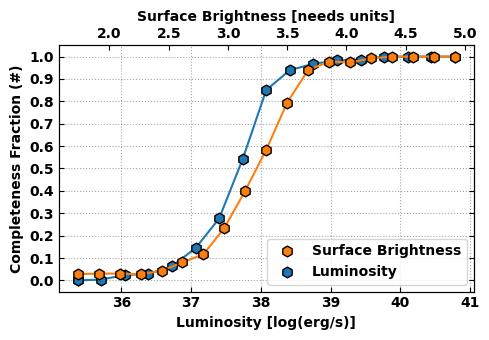

In [58]:
data_x1 = Lcent
data_y1 = Lcomp_num
data_x2 = Scent
data_y2 = Scomp_num

fig = plt.figure(figsize=(5, 3.5)) 
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(data_x1, data_y1)
ax2.plot(data_x2, data_y2, color='C1')

ax1.scatter(data_x1[0], data_y1[0], s=60, ec='black', fc='C1', zorder=10, marker='h', lw=1, label='Surface Brightness')
ax1.scatter(data_x1, data_y1, s=60, ec='black', fc='C0', zorder=10, marker='h', lw=1, label='Luminosity')
ax2.scatter(data_x2, data_y2, s=60, ec='black', fc='C1', zorder=10, marker='h', lw=1, label='Surface Brightness')

ax1.grid(True, alpha=0.35, ls=':', color='black')

ax1.set_xlabel('Luminosity [log(erg/s)]')
ax1.set_ylabel('Completeness Fraction (#)')
ax2.set_xlabel('Surface Brightness [needs units]')

ax1.legend(loc='lower right')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

ax1.set_yticks(np.arange(0, 1.1, 0.1))

plt.savefig('./figs/scatter_completenessfrac.pdf', dpi=200, bbox_inches='tight')

In [ ]:
# data_x1 = Lcent
# data_y1 = Lcomp

# fig = plt.figure(figsize=(5, 3.5)) 
# ax1 = fig.add_subplot(111)
# ax2 = ax1.twiny()

# ax1.plot(data_x1, data_y1)

# ax1.scatter(data_x1, data_y1, s=60, ec='black', fc='C0', zorder=10, marker='h', lw=1, label='Luminosity')

# ax1.grid(True, alpha=0.35, ls=':', color='black')

# ax1.set_xlabel('Luminosity [log(erg/s)]')
# ax1.set_ylabel('Completeness Fraction (#)')
# ax2.set_xlabel('Surface Brightness [needs units]')

# ax1.legend(loc='lower right')

# fig.tight_layout(h_pad=0.5, w_pad=0.5)

# # ax1.set_yticks(np.arange(0, 1.1, 0.1))

# plt.savefig('./figs/scatter_completenessfrac.pdf', dpi=200, bbox_inches='tight')